# Food Classification

> In this project we are going to classify Images into three wonderful food classes that are **Pizza, Steak and Sushi**!!!

In [1]:
import torch
from torch import nn

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(f'PyTorch version: {torch.__version__}')
print(f'PyTorch Vision version: {torchvision.__version__}')

PyTorch version: 2.1.0+cu118
PyTorch Vision version: 0.16.0+cu118


Mount Google drive to get data

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
data_path = '/content/drive/MyDrive/pizza_steak_sushi_20_percent.zip'

import zipfile
zip_ref = zipfile.ZipFile(data_path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Creating Image Transforming Pipelines
* First we use the `torchvision.transforms.Compose` to make a pipeline of transformations from `torchvision.transforms`


In [5]:
IMAGE_SIZE = (224, 224)

In [6]:
# Training Transform pipeline has many transform functions
train_transform = transforms.Compose([
    transforms.Resize(size=IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.65),
    transforms.TrivialAugmentWide(num_magnitude_bins=20),
    transforms.ToTensor()
])

# Testing Transform Pipeline - we do not need much transform functions
test_transform = transforms.Compose([
    transforms.Resize(size=IMAGE_SIZE),
    transforms.ToTensor()
])

## Loading our Data

It's important to load in our data, so that we can build a PyTorch model on it

* We will load our data using `torchvision.datasets.ImageFolder`, which takes in prominently to parameters that are: Data path and Image transformation pipeline

In [7]:
train_dir = '/content/train/'
test_dir = '/content/test/'

In [8]:
train_data = ImageFolder(
    root=train_dir,
    transform=train_transform
)

test_data = ImageFolder(
    root=test_dir,
    transform=test_transform
)

In [9]:
len(train_data), len(test_data)

(450, 150)

In [10]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

Image Shape: torch.Size([3, 224, 224])
Image Datatype: torch.float32
Pizel Values range from: 0.0 to 1.0


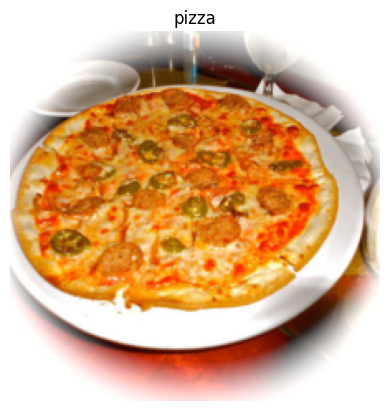

In [11]:
aug_image, label = train_data[1]
plt.imshow(aug_image.permute([1, 2, 0]))
plt.axis('off')
plt.title(class_names[label])

# Print contents of image
print(f'Image Shape: {aug_image.shape}')
print(f'Image Datatype: {aug_image.dtype}')
print(f'Pizel Values range from: {torch.min(aug_image)} to {torch.max(aug_image)}')

### Convert PyTorch Dataset to Dataloaders

Essentially, a good practice is to convert our dataset, into batches of size 32 (most common batch size). This will prevent our ram from overloading and also has a lot of benefits

**Note:** Our model's parameters will be getting updated using `Gradient Descent`, every batch it goes through in the training data

* We will use:  `torch.utils.data.DataLoader()`

In [12]:
BATCH_SIZE = 32

import os
NUM_WORKERS = os.cpu_count()

In [13]:
# Convert into Data Loaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

In [14]:
print(f'Train Dataset has {len(train_dataloader)} batches of size {train_dataloader.batch_size}')
print(f'Test Dataset has {len(test_dataloader)} batches of size {test_dataloader.batch_size}')
print(f'CPU processing units: {train_dataloader.num_workers}')

Train Dataset has 15 batches of size 32
Test Dataset has 5 batches of size 32
CPU processing units: 2


In [15]:
img_batch, labels_batch = next(iter(train_dataloader))
img_batch.shape, labels_batch

(torch.Size([32, 3, 224, 224]),
 tensor([2, 1, 0, 1, 2, 0, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 0, 2, 2,
         2, 2, 1, 0, 2, 0, 1, 2]))

Text(0.5, 1.0, 'pizza')

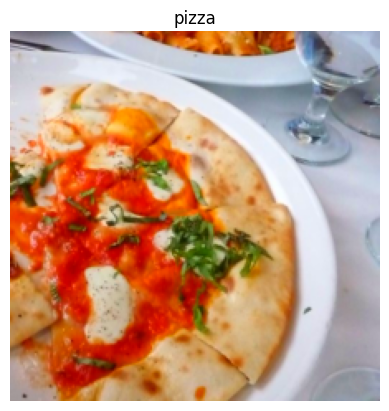

In [16]:
# Plotting random Image
import random
random_idx = random.randint(0, train_dataloader.batch_size)
plt.imshow(img_batch[random_idx].permute([1, 2, 0]))
plt.axis('off')
plt.title(class_names[labels_batch[random_idx]])

## Constructing PyTorch Model

In [17]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
class FoodVisionMiniV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=32*26*26, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=3),
    )

  def forward(self, X:torch.tensor) -> torch.tensor:
    X = self.conv_block1(X)
    # print(f'Image Shape after conv_block1: {X.shape}')
    X = self.conv_block2(X)
    # print(f'Image Shape after conv_block2: {X.shape}')
    X = self.classifier(X)
    return X


model = FoodVisionMiniV0().to(device)
model

FoodVisionMiniV0(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=21632, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=3,

### Dummy Forward Pass with random Image, to find out the parameters of model

In [19]:
aug_image.shape

torch.Size([3, 224, 224])

In [20]:
model.eval()
with torch.inference_mode():
  logits = model(aug_image.unsqueeze(dim=0).to(device))
preds = torch.argmax(torch.softmax(logits, dim=1), dim=1)
print(f'Predictions: label {preds} therefore, class {class_names[preds.item()]}')
print(f'Ground Truth: {class_names[label]}')

Predictions: label tensor([2], device='cuda:0') therefore, class sushi
Ground Truth: pizza


### Summary of our model

In [21]:
!pip install torchinfo

In [22]:
import torchinfo
from torchinfo import summary
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
FoodVisionMiniV0                         [32, 3]                   --
├─Sequential: 1-1                        [32, 16, 110, 110]        --
│    └─Conv2d: 2-1                       [32, 16, 222, 222]        448
│    └─ReLU: 2-2                         [32, 16, 222, 222]        --
│    └─Conv2d: 2-3                       [32, 16, 220, 220]        2,320
│    └─ReLU: 2-4                         [32, 16, 220, 220]        --
│    └─MaxPool2d: 2-5                    [32, 16, 110, 110]        --
├─Sequential: 1-2                        [32, 32, 26, 26]          --
│    └─Conv2d: 2-6                       [32, 32, 108, 108]        4,640
│    └─ReLU: 2-7                         [32, 32, 108, 108]        --
│    └─MaxPool2d: 2-8                    [32, 32, 54, 54]          --
│    └─Conv2d: 2-9                       [32, 32, 52, 52]          9,248
│    └─ReLU: 2-10                        [32, 32, 52, 52]          --
│    

### Setting up Loss Function and Optimizer

In [23]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-3,
                             eps=1e-07)

In [24]:
next(model.parameters()).device

device(type='cuda', index=0)

Set up Accuracy Function


In [25]:
def accuracy_fn(y_true, y_preds):
  correct = torch.eq(y_true, y_preds).sum().item()
  acc = correct/len(y_true)
  return acc

## Training Our Model

We will be using a long peice of code to train our model, taking each batch of the training and testing dataset into account

In [26]:
EPOCHS = 50

# Add loss and acc to these tracking lists per epoch
train_loss_track, train_acc_track = [], []
test_loss_track, test_acc_track = [], []

# Iterate through epochs
for epoch in range(EPOCHS):
  print(f'Epoch: {epoch} \n----------------')

  # set model to train mode
  model.train()

  train_loss, train_acc = 0, 0

  # Iterate through each batch
  for batch, (X, y) in enumerate(train_dataloader):
    # set X and y to target device
    X, y = X.to(device), y.to(device)

    # Forward Pass
    y_logits = model(X)
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    # Calculate loss and acc
    batch_loss = loss_fn(y_logits, y)

    train_loss += batch_loss.item()
    train_acc += accuracy_fn(y, y_preds)


    # Zero grad
    optimizer.zero_grad()
    # Backpropagation
    batch_loss.backward()
    # Gradient Descent
    optimizer.step()

  # Calculate the average of all loss and acc values in dataloader
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  # Testing time
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)

      # Forward Pass
      test_logits = model(X)
      test_preds = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

      # Calculate loss and acc
      test_loss += loss_fn(test_logits, y).item()
      test_acc += accuracy_fn(y, test_preds)

    # Calculate the average of all loss and acc values in dataloader
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  # Updating all tracking variables
  train_loss_track.append(train_loss)
  train_acc_track.append(train_acc)
  test_loss_track.append(test_loss)
  test_acc_track.append(test_acc)

  # Print out what's happenin`
  print(f'Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.3f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.3f}%')





Epoch: 0 
----------------
Train Loss: 1.10078 | Train Accuracy: 0.338% | Test Loss: 1.09953 | Test Accuracy: 0.350%
Epoch: 1 
----------------
Train Loss: 1.09806 | Train Accuracy: 0.348% | Test Loss: 1.09660 | Test Accuracy: 0.426%
Epoch: 2 
----------------
Train Loss: 1.08118 | Train Accuracy: 0.423% | Test Loss: 1.04837 | Test Accuracy: 0.460%
Epoch: 3 
----------------
Train Loss: 1.01375 | Train Accuracy: 0.527% | Test Loss: 0.98608 | Test Accuracy: 0.524%
Epoch: 4 
----------------
Train Loss: 0.95793 | Train Accuracy: 0.521% | Test Loss: 0.89991 | Test Accuracy: 0.626%
Epoch: 5 
----------------
Train Loss: 0.98944 | Train Accuracy: 0.477% | Test Loss: 0.90187 | Test Accuracy: 0.590%
Epoch: 6 
----------------
Train Loss: 0.95865 | Train Accuracy: 0.506% | Test Loss: 0.91746 | Test Accuracy: 0.508%
Epoch: 7 
----------------
Train Loss: 0.92643 | Train Accuracy: 0.481% | Test Loss: 0.92347 | Test Accuracy: 0.581%
Epoch: 8 
----------------
Train Loss: 0.95080 | Train Accuracy:

## Evaluating our model

It's very  important to evaluate our model, so that we can make a decision if the model's performance is okay, or whether we have to experiment more and find out a better model!!

* Firstly, Evaluate our model on many other classification metrics (Classification Report)
* Plotting all Loss and Accuracy Curves
* Build a Confusion Matrix
* Make Predictions on Custom Images

In [27]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.0 MB/s eta 0:00:00


In [28]:
# Making Predictions
predictions = []
model.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    y_preds = list(torch.argmax(torch.softmax(model(X), dim=1), dim=1).squeeze().cpu().numpy())
    predictions.extend(y_preds)
predictions = torch.tensor(predictions)

In [29]:
predictions

tensor([0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 2, 0, 2, 1, 0, 2, 0, 1, 0, 2, 0, 2, 2,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1, 1, 2, 0, 2, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 0, 1, 2, 2, 0, 1, 2, 0, 2, 1,
        1, 0, 2, 1, 2, 0, 2, 0, 0, 1, 2, 2, 2, 2, 0, 1, 1, 2, 1, 0, 1, 0, 2, 1,
        0, 1, 1, 1, 2, 0])

### Classification Report

In [30]:
from torchmetrics import Accuracy, Precision, Recall, F1Score

def torch_metrics(preds, target):

  torchmetric_acc = Accuracy(task="multiclass", num_classes=3, average='macro')
  acc = torchmetric_acc(preds, target)

  torchmetric_precision = Precision(task="multiclass", num_classes=3, average='macro')
  precision = torchmetric_precision(preds, target)

  torchmetric_recall = Recall(task="multiclass", num_classes=3, average='macro')
  recall = torchmetric_recall(preds, target)

  torchmetric_f1 = F1Score(task="multiclass", num_classes=3, average='macro')
  f1 = torchmetric_f1(preds, target)

  return {"Accuracy": acc.item(), "Precision": precision.item(), "Recall": recall.item(), "F1 Score": f1.item()}

model_results = torch_metrics(preds=predictions, target=torch.tensor(test_data.targets))
model_results

{'Accuracy': 0.5644677877426147,
 'Precision': 0.5552206039428711,
 'Recall': 0.5644677877426147,
 'F1 Score': 0.5575458407402039}

### Plotting loss and accuracy curves

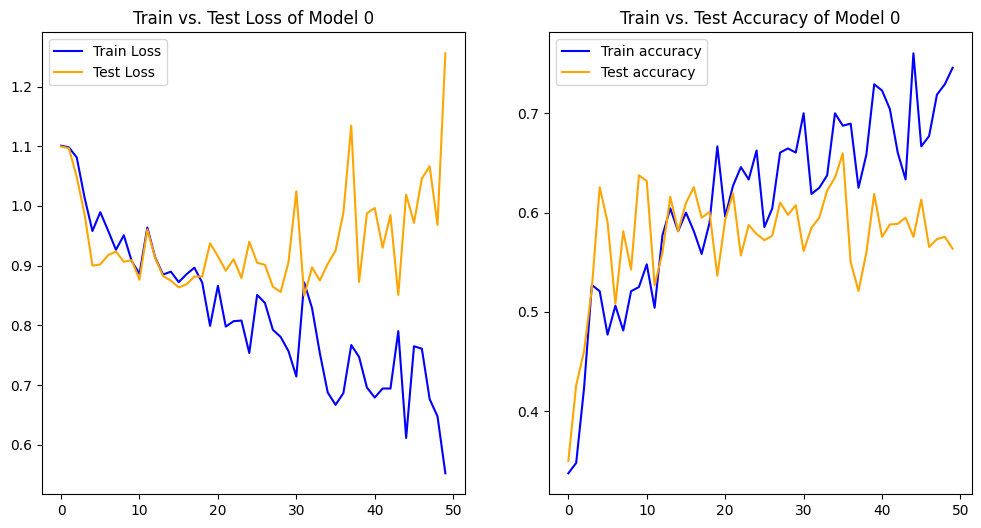

In [31]:
# Plotting loss curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Train vs. Test Loss of Model 0')
plt.plot(range(50), train_loss_track, c='blue', label='Train Loss')
plt.plot(range(50), test_loss_track, c='orange', label='Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Train vs. Test Accuracy of Model 0')
plt.plot(range(50), train_acc_track, c='blue', label='Train accuracy')
plt.plot(range(50), test_acc_track, c='orange', label='Test accuracy')
plt.legend()

### Building Confusion Matrix

In [32]:
from torchmetrics import ConfusionMatrix
confmat = ConfusionMatrix(task="multiclass", num_classes=3)
matrix = confmat(predictions, torch.tensor(test_data.targets))
matrix

tensor([[28,  4, 14],
        [ 6, 44,  8],
        [14, 17, 15]])

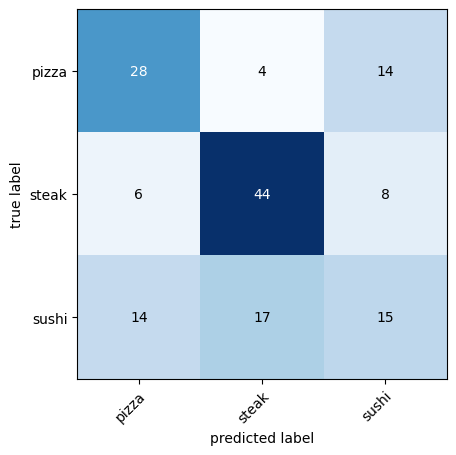

In [33]:
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=matrix.numpy(),
                                class_names=class_names,
                                cmap=plt.cm.Blues)
plt.show()

### Making Predictions with Custom images

In [34]:
def generate_random_nums(lower_bound=0, upper_bound=150):
  # Generate a list of 100 random numbers
  random_numbers = []
  for i in range(9):
      random_number = random.randint(lower_bound, upper_bound)
      random_numbers.append(random_number)

  return random_numbers

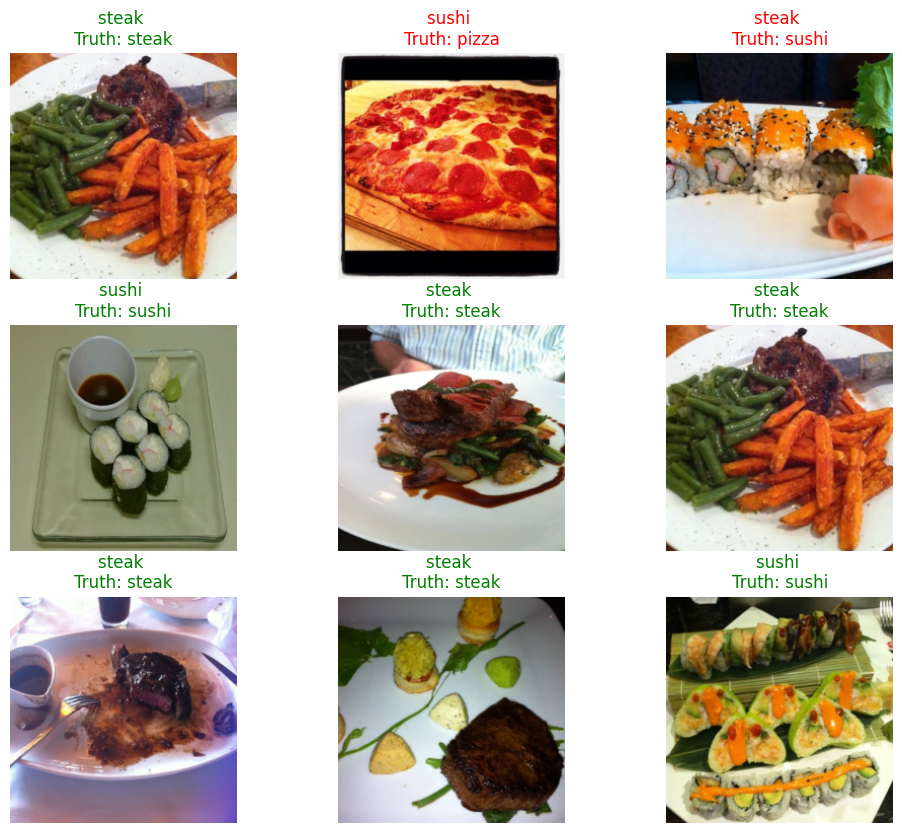

In [37]:
plt.figure(figsize=(12, 10))

nrows = 3
ncols=3
random_idx = generate_random_nums()

for i, num in enumerate(random_idx):
  plt.subplot(nrows, ncols, i+1)

  truth_label = test_data.targets[num]
  pred_label = predictions[num].item()
  img = test_data[num][0]

  plt.imshow(img.permute([1, 2, 0]))
  plt.axis('off')

  title = f'{class_names[pred_label]} \nTruth: {class_names[truth_label]}'

  if pred_label == truth_label:
    plt.title(title, c='g')
  else:
    plt.title(title, c='r')

## Saving and Re-loading our PyTorch model

It's very essential to save our model, so that we can use it for Deployment, or while making an App powered by a Deep Learning PyTorch Model

In [38]:
torch.save(model.state_dict(), 'foodvision_mini_model.pt')